# Regression Challenge

## Loading the data

Let's begin by loading the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_prices = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

In [2]:
house_prices.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [3]:
house_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

## Data cleaning, exploratory data analysis, and feature engineering

Let's start exploration by visualizing the target value with a distribution.

(array([148., 723., 373., 135.,  51.,  19.,   4.,   3.,   2.,   2.]),
 array([ 34900., 106910., 178920., 250930., 322940., 394950., 466960.,
        538970., 610980., 682990., 755000.]),
 <a list of 10 Patch objects>)

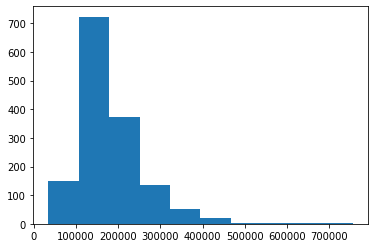

In [4]:
plt.hist(house_prices.saleprice)

The variable is not normally distributed. We might want to transform it later on.

Now to check for null values.

In [5]:
total = house_prices.isnull().sum().sort_values(ascending=False)
percent = (house_prices.isnull().sum()*100/house_prices.isnull().count()).sort_values(ascending = False)
missing_values = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_values.head(20)

,Total,Percent
poolqc,1453,99.520548
miscfeature,1406,96.301370
alley,1369,93.767123
fence,1179,80.753425
fireplacequ,690,47.260274
lotfrontage,259,17.739726
garagecond,81,5.547945
garagetype,81,5.547945
garageyrblt,81,5.547945
garagefinish,81,5.547945


We'll impute the mean for the null numeric values, and impute a "Unknown" category for null catergorical variables.

In [6]:
house_prices.fillna(house_prices.mean(), inplace=True)

In [7]:
house_prices.fillna(("Unknown"), inplace=True)

In [8]:
clean_house_prices = house_prices.copy()

In [9]:
total = clean_house_prices.isnull().sum().sort_values(ascending=False)
percent = (clean_house_prices.isnull().sum()*100/clean_house_prices.isnull().count()).sort_values(ascending = False)
missing_values = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_values.head(20)

,Total,Percent
saleprice,0,0.0
heating,0,0.0
roofstyle,0,0.0
roofmatl,0,0.0
exterior1st,0,0.0
exterior2nd,0,0.0
masvnrtype,0,0.0
masvnrarea,0,0.0
exterqual,0,0.0
extercond,0,0.0


Now we have no null values.

We'll use describe() to get some descriptive stats about our data.

In [10]:
clean_house_prices.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,22.024023,9981.264932,1.382997,1.112799,30.202904,20.645407,180.569112,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,70.049958,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


For univariate analysis, we'll make distributions of the variables.

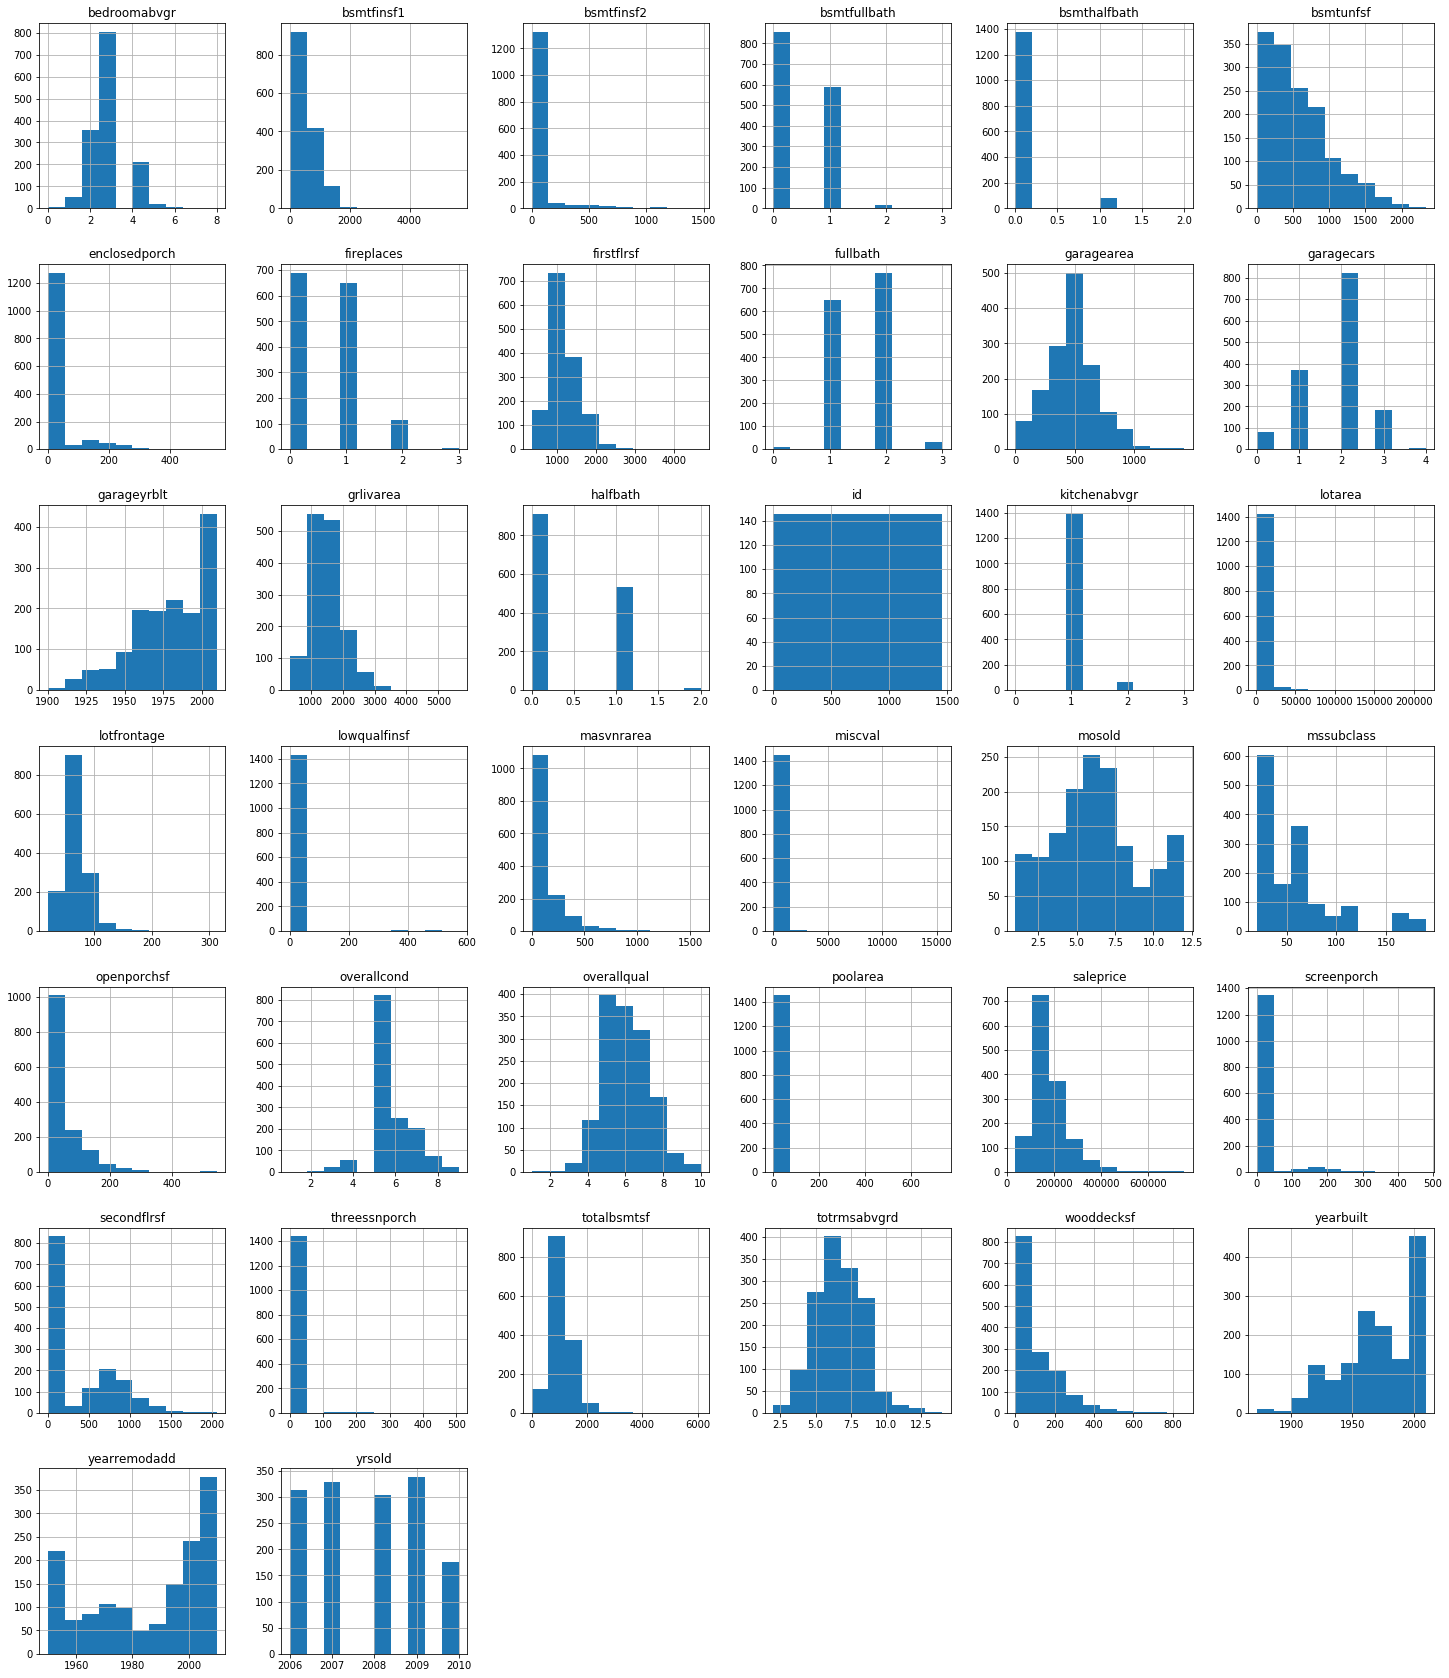

In [11]:
clean_house_prices.hist(figsize=(25,30))
plt.show()

Now, we need to remove the outliers. First, we need to identify them.

In [12]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

newdf = clean_house_prices.select_dtypes(include=numerics)

In [13]:
for variable in newdf:
    q75, q25 = np.percentile(clean_house_prices[variable], [75 ,25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    print("Number of outliers and percentage of it in {} : {} and {}".format(variable,
len((np.where((clean_house_prices[variable] > max_val) | 
(clean_house_prices[variable] < min_val))[0])),len((np.where((clean_house_prices[variable] > max_val) | 
(clean_house_prices[variable] < min_val))[0]))*100/1460))

Number of outliers and percentage of it in id : 0 and 0.0
Number of outliers and percentage of it in mssubclass : 103 and 7.054794520547945
Number of outliers and percentage of it in lotfrontage : 106 and 7.260273972602739
Number of outliers and percentage of it in lotarea : 69 and 4.726027397260274
Number of outliers and percentage of it in overallqual : 2 and 0.136986301369863
Number of outliers and percentage of it in overallcond : 125 and 8.561643835616438
Number of outliers and percentage of it in yearbuilt : 7 and 0.4794520547945205
Number of outliers and percentage of it in yearremodadd : 0 and 0.0
Number of outliers and percentage of it in masvnrarea : 98 and 6.712328767123288
Number of outliers and percentage of it in bsmtfinsf1 : 7 and 0.4794520547945205
Number of outliers and percentage of it in bsmtfinsf2 : 167 and 11.438356164383562
Number of outliers and percentage of it in bsmtunfsf : 29 and 1.9863013698630136
Number of outliers and percentage of it in totalbsmtsf : 61 a

To remove these outliers, we are going to winsorize. We will then add them to the dataset, and remove the old variables. We will not winsorize if it results in all of the values becoming 0.

In [14]:
mssubclass_winsorized = winsorize(clean_house_prices["mssubclass"], (0, 0.09))
lotfrontage_winsorized = winsorize(clean_house_prices["lotfrontage"], (0.04, 0.04))
lotarea_winsorized = winsorize(clean_house_prices["lotarea"], (0.01, 0.05))
overallqual_winsorized = winsorize(clean_house_prices["overallqual"], (0.01, 0))
overallcond_winsorized = winsorize(clean_house_prices["overallcond"], (0.03, 0.07))
masvnrarea_winsorized = winsorize(clean_house_prices["masvnrarea"], (0, 0.07))
bsmtfinsf1_winsorized = winsorize(clean_house_prices["bsmtfinsf1"], (0, 0.005))
bsmtfinsf2_winsorized = winsorize(clean_house_prices["bsmtfinsf2"], (0, 0.12))
bsmtunfsf_winsorized = winsorize(clean_house_prices["bsmtunfsf"], (0, 0.01))
totalbsmtsf_winsorized = winsorize(clean_house_prices["totalbsmtsf"], (0.03, 0.02))
firstflrsf_winsorized = winsorize(clean_house_prices["firstflrsf"], (0, 0.02))
secondflrsf_winsorized = winsorize(clean_house_prices["secondflrsf"], (0, 0.01))
lowqualfinsf_winsorized = winsorize(clean_house_prices["lowqualfinsf"], (0, 0.02))
grlivarea_winsorized = winsorize(clean_house_prices["grlivarea"], (0, 0.03))
bsmtfullbath_winsorized = winsorize(clean_house_prices["bsmtfullbath"], (0, 0.01))
bsmthalfbath_winsorized = winsorize(clean_house_prices["bsmthalfbath"], (0, 0.06))
bedroomabvgr_winsorized = winsorize(clean_house_prices["bedroomabvgr"], (0.01, 0.05))
kitchenabvgr_winsorized = winsorize(clean_house_prices["kitchenabvgr"], (0.01, 0.05))
totrmsabvgrd_winsorized = winsorize(clean_house_prices["totrmsabvgrd"], (0, 0.03))
fireplaces_winsorized = winsorize(clean_house_prices["fireplaces"], (0, 0.01))
garageyrblt_winsorized = winsorize(clean_house_prices["garageyrblt"], (0.09,0))
garagecars_winsorized = winsorize(clean_house_prices["garagecars"], (0, 0.05))
garagearea_winsorized = winsorize(clean_house_prices["garagearea"], (0, 0.03))
wooddecksf_winsorized = winsorize(clean_house_prices["wooddecksf"], (0, 0.03))
openporchsf_winsorized = winsorize(clean_house_prices["openporchsf"], (0, 0.06))
enclosedporch_winsorized = winsorize(clean_house_prices["enclosedporch"], (0, 0.15))
threessnporch_winsorized = winsorize(clean_house_prices["threessnporch"], (0, 0.05))
screenporch_winsorized = winsorize(clean_house_prices["screenporch"], (0, 0.10))
poolarea_winsorized = winsorize(clean_house_prices["poolarea"], (0, 0.05))
miscval_winsorized = winsorize(clean_house_prices["miscval"], (0, 0.05))
saleprice_winsorized = winsorize(clean_house_prices["saleprice"], (0, 0.05))

In [15]:
clean_house_prices['mssubclass_winsorized'] = mssubclass_winsorized
clean_house_prices['lotfrontage_winsorized'] = lotfrontage_winsorized
clean_house_prices['lotarea_winsorized'] = lotarea_winsorized
clean_house_prices['overallqual_winsorized'] = overallqual_winsorized
clean_house_prices['overallcond_winsorized'] = overallcond_winsorized
clean_house_prices['masvnrarea_winsorized'] = masvnrarea_winsorized
clean_house_prices['bsmtfinsf1_winsorized'] = bsmtfinsf1_winsorized
clean_house_prices['bsmtunfsf_winsorized'] = bsmtunfsf_winsorized
clean_house_prices['totalbsmtsf_winsorized'] = totalbsmtsf_winsorized
clean_house_prices['firstflrsf_winsorized'] = firstflrsf_winsorized
clean_house_prices['secondflrsf_winsorized'] = secondflrsf_winsorized
clean_house_prices['grlivarea_winsorized'] = grlivarea_winsorized
clean_house_prices['bsmtfullbath_winsorized'] = bsmtfullbath_winsorized
clean_house_prices['bedroomabvgr_winsorized'] = bedroomabvgr_winsorized
clean_house_prices['totrmsabvgrd_winsorized'] = totrmsabvgrd_winsorized
clean_house_prices['fireplaces_winsorized'] = fireplaces_winsorized
clean_house_prices['garageyrblt_winsorized'] = garageyrblt_winsorized
clean_house_prices['garagecars_winsorized'] = garagecars_winsorized
clean_house_prices['garagearea_winsorized'] = garagearea_winsorized
clean_house_prices['wooddecksf_winsorized'] = wooddecksf_winsorized
clean_house_prices['openporchsf_winsorized'] = openporchsf_winsorized
clean_house_prices['saleprice_winsorized'] = saleprice_winsorized

In [16]:
clean_house_prices = clean_house_prices.drop(['mssubclass', 'lotfrontage','lotarea','overallqual','overallcond','masvnrarea','bsmtfinsf1',
                        'bsmtunfsf','totalbsmtsf','firstflrsf','secondflrsf','grlivarea',
                        'bsmtfullbath','bedroomabvgr','totrmsabvgrd','fireplaces','garageyrblt',
                        'garagecars','garagearea','wooddecksf','openporchsf','saleprice',], axis=1)

Next, we'll use a correlation matrix to see with variables correlate with salesprice.

In [17]:
corr_mat_houses = clean_house_prices.corr()

corr_mat_houses.sort_values(by=['saleprice_winsorized'],ascending=False)

,id,yearbuilt,yearremodadd,bsmtfinsf2,lowqualfinsf,bsmthalfbath,fullbath,halfbath,kitchenabvgr,enclosedporch,...,bsmtfullbath_winsorized,bedroomabvgr_winsorized,totrmsabvgrd_winsorized,fireplaces_winsorized,garageyrblt_winsorized,garagecars_winsorized,garagearea_winsorized,wooddecksf_winsorized,openporchsf_winsorized,saleprice_winsorized
saleprice_winsorized,-0.027107,0.573333,0.556189,-0.006533,-0.041494,-0.026427,0.587478,0.296301,-0.150762,-0.141650,...,0.239732,0.210943,0.538633,0.490271,0.531018,0.679405,0.661919,0.345971,0.398170,1.000000
overallqual_winsorized,-0.029403,0.573713,0.550217,-0.060715,-0.031152,-0.041392,0.549730,0.275487,-0.186443,-0.116323,...,0.113887,0.119652,0.433616,0.397798,0.559944,0.608540,0.569293,0.249137,0.360846,0.818675
grlivarea_winsorized,0.002446,0.216046,0.298105,-0.007387,0.107428,-0.027108,0.641447,0.435384,0.112384,0.008611,...,0.020991,0.545048,0.835204,0.462246,0.257145,0.489926,0.472369,0.242088,0.349112,0.730062
garagecars_winsorized,0.013672,0.546073,0.425546,-0.037340,-0.094944,-0.023883,0.476141,0.219548,-0.058617,-0.157262,...,0.133821,0.111137,0.372320,0.308721,0.515214,1.000000,0.897416,0.235597,0.267269,0.679405
garagearea_winsorized,0.011332,0.489428,0.378785,-0.014313,-0.068584,-0.022771,0.417366,0.164060,-0.065088,-0.123127,...,0.182370,0.099339,0.339061,0.268878,0.499370,0.897416,1.000000,0.234314,0.278300,0.661919
totalbsmtsf_winsorized,-0.024599,0.417627,0.300249,0.105433,-0.037247,-0.002711,0.345133,-0.082795,-0.040888,-0.111363,...,0.302578,0.050844,0.277654,0.330898,0.335841,0.470877,0.495386,0.242894,0.250823,0.650398
firstflrsf_winsorized,0.005138,0.288910,0.248025,0.100528,-0.013004,0.003812,0.382966,-0.136940,0.073600,-0.082304,...,0.237522,0.126255,0.400079,0.403546,0.229957,0.460705,0.488498,0.238789,0.204603,0.620613
fullbath,0.005587,0.468271,0.439046,-0.076444,-0.000710,-0.054536,1.000000,0.136381,0.133115,-0.115093,...,-0.068314,0.361906,0.556469,0.245253,0.504320,0.476141,0.417366,0.203088,0.300782,0.587478
yearbuilt,-0.012713,1.000000,0.592855,-0.049107,-0.183784,-0.038162,0.468271,0.242656,-0.174800,-0.387268,...,0.187906,-0.044638,0.105147,0.148403,0.776360,0.546073,0.489428,0.242480,0.263998,0.573333
yearremodadd,-0.021998,0.592855,1.000000,-0.067759,-0.062419,-0.012337,0.439046,0.183331,-0.149598,-0.193919,...,0.119904,-0.030151,0.196675,0.110941,0.651030,0.425546,0.378785,0.226914,0.282842,0.556189


In [18]:
corr_mat_houses.sort_values(by=['saleprice_winsorized'],ascending=True)

,id,yearbuilt,yearremodadd,bsmtfinsf2,lowqualfinsf,bsmthalfbath,fullbath,halfbath,kitchenabvgr,enclosedporch,...,bsmtfullbath_winsorized,bedroomabvgr_winsorized,totrmsabvgrd_winsorized,fireplaces_winsorized,garageyrblt_winsorized,garagecars_winsorized,garagearea_winsorized,wooddecksf_winsorized,openporchsf_winsorized,saleprice_winsorized
kitchenabvgr,0.002951,-0.174800,-0.149598,-0.040751,0.007522,-0.037944,0.133115,-0.068263,1.000000,0.037312,...,-0.041443,0.150728,0.241763,-0.124771,-0.099616,-0.058617,-0.065088,-0.092678,-0.081880,-0.150762
enclosedporch,0.002889,-0.387268,-0.193919,0.036543,0.061081,-0.008555,-0.115093,-0.095317,0.037312,1.000000,...,-0.049699,0.049161,0.008463,-0.023278,-0.269477,-0.157262,-0.123127,-0.128530,-0.109431,-0.141650
overallcond_winsorized,0.003042,-0.409890,0.009445,0.055333,0.033409,0.101269,-0.241675,-0.076769,-0.096813,0.088529,...,-0.050496,0.003164,-0.091393,-0.039752,-0.354940,-0.232941,-0.192321,-0.020875,-0.099323,-0.122322
lowqualfinsf,-0.044230,-0.183784,-0.062419,0.014807,1.000000,-0.005842,-0.000710,-0.027080,0.007522,0.061081,...,-0.047235,0.057443,0.091820,-0.020962,-0.028326,-0.094944,-0.068584,-0.026403,0.012509,-0.041494
yrsold,0.000712,-0.013618,0.035743,0.031706,-0.028921,-0.046524,-0.019669,-0.010269,0.031687,-0.009916,...,0.066222,-0.032300,-0.040437,-0.026042,-0.005590,-0.040183,-0.029709,0.026655,-0.056918,-0.032102
mssubclass_winsorized,0.017370,0.064795,0.069449,-0.073240,0.045253,0.009901,0.166303,0.210911,0.260353,-0.010307,...,-0.000576,-0.053732,0.069736,-0.006955,0.125379,0.001959,-0.067979,0.001375,0.012945,-0.031714
id,1.000000,-0.012713,-0.021998,-0.005968,-0.044230,-0.020155,0.005587,0.006784,0.002951,0.002889,...,0.002274,0.041722,0.021054,-0.018479,-0.003330,0.013672,0.011332,-0.034810,-0.011844,-0.027107
bsmthalfbath,-0.020155,-0.038162,-0.012337,0.070948,-0.005842,1.000000,-0.054536,-0.012340,-0.037944,-0.008555,...,-0.148338,0.043418,-0.025999,0.030739,-0.081876,-0.023883,-0.022771,0.047136,-0.030593,-0.026427
miscval,-0.006242,-0.034383,-0.010286,0.004940,-0.003793,-0.007367,-0.014290,0.001290,0.062341,0.018361,...,-0.023053,0.006524,0.009361,0.001904,-0.037206,-0.043140,-0.028523,-0.011877,-0.030234,-0.019959
bsmtfinsf2,-0.005968,-0.049107,-0.067759,1.000000,0.014807,0.070948,-0.076444,-0.032148,-0.040751,0.036543,...,0.159906,-0.017494,-0.038043,0.044085,-0.108222,-0.037340,-0.014313,0.069432,-0.018553,-0.006533


Let's create some variables that might be helpful for the model.

In [19]:
clean_house_prices['totalsf'] = clean_house_prices['totalbsmtsf_winsorized'] + clean_house_prices['firstflrsf_winsorized'] + clean_house_prices['secondflrsf_winsorized']

clean_house_prices['quality_per_sf'] =  clean_house_prices['overallqual_winsorized']/clean_house_prices['totalsf'] 

We will create a dummy variable for zoning type as features because of their correlation with sales price.

In [20]:
clean_house_prices = pd.concat([clean_house_prices,pd.get_dummies(clean_house_prices.mszoning, prefix="mszoning", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(clean_house_prices.mszoning, prefix="mszoning", drop_first=True).columns)

## Creating the model

Now let's create the OLS model. We'll transform the salesprice variable because it is not normally distributed.

In [21]:
Y = np.log1p(clean_house_prices['saleprice_winsorized'])
X = clean_house_prices[['overallqual_winsorized','grlivarea_winsorized','overallcond_winsorized','garagearea_winsorized','fullbath','yearbuilt','garagecars_winsorized','totalsf','quality_per_sf','kitchenabvgr','enclosedporch']+ dummy_column_names]
X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     saleprice_winsorized   R-squared:                       0.873
Model:                              OLS   Adj. R-squared:                  0.872
Method:                   Least Squares   F-statistic:                     530.0
Date:                  Mon, 13 Jan 2020   Prob (F-statistic):               0.00
Time:                          00:43:28   Log-Likelihood:                 699.76
No. Observations:                  1168   AIC:                            -1368.
Df Residuals:                      1152   BIC:                            -1287.
Df Model:                            15                                         
Covariance Type:              nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      5.0357      0.448     11.247      0.000       4.157       5.914
overallqual_winsorized     0.1283      0.010     12.391      0.000       0.108       0.149
grlivarea_winsorized       0.0001   1.91e-05      7.645      0.000       0.000       0.000
overallcond_winsorized     0.0755      0.005     14.958      0.000       0.066       0.085
garagearea_winsorized   5.952e-05   4.51e-05      1.321      0.187   -2.89e-05       0.000
fullbath                  -0.0158      0.011     -1.464      0.143      -0.037       0.005
yearbuilt                  0.0028      0.000     12.415      0.000       0.002       0.003
garagecars_winsorized      0.0571      0.013      4.360      0.000       0.031       0.083
totalsf                 2.509e-05   2.42e-05      1.036      0.300   -2.24e-05    7.26e-05
quality_per_sf          -146.8544     21.983     -6.680      0.000    -189.985    -103.724
kitchenabvgr              -0.0761      0.020     -3.883      0.000      -0.115      -0.038
enclosedporch              0.0001   7.01e-05      1.997      0.046    2.46e-06       0.000
mszoning_FV                0.3879      0.053      7.297      0.000       0.284       0.492
mszoning_RH                0.2953      0.060      4.901      0.000       0.177       0.414
mszoning_RL                0.3379      0.049      6.904      0.000       0.242       0.434
mszoning_RM                0.2240      0.049      4.537      0.000       0.127       0.321
==============================================================================
Omnibus:                      368.940   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2653.033
Skew:                          -1.263   Prob(JB):                         0.00
Kurtosis:                       9.938   Cond. No.                     2.06e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.06e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We will remove insignificant variables and rerun.

In [22]:
Y = np.log1p(clean_house_prices['saleprice_winsorized'])
X = clean_house_prices[['overallqual_winsorized','grlivarea_winsorized','overallcond_winsorized','yearbuilt','garagecars_winsorized','quality_per_sf','kitchenabvgr']+ dummy_column_names]
X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     saleprice_winsorized   R-squared:                       0.872
Model:                              OLS   Adj. R-squared:                  0.871
Method:                   Least Squares   F-statistic:                     718.3
Date:                  Mon, 13 Jan 2020   Prob (F-statistic):               0.00
Time:                          00:43:28   Log-Likelihood:                 694.84
No. Observations:                  1168   AIC:                            -1366.
Df Residuals:                      1156   BIC:                            -1305.
Df Model:                            11                                         
Covariance Type:              nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      5.5442      0.404     13.718      0.000       4.751       6.337
overallqual_winsorized     0.1382      0.006     22.940      0.000       0.126       0.150
grlivarea_winsorized       0.0001   1.66e-05      8.577      0.000       0.000       0.000
overallcond_winsorized     0.0753      0.005     14.979      0.000       0.065       0.085
yearbuilt                  0.0026      0.000     12.543      0.000       0.002       0.003
garagecars_winsorized      0.0711      0.007      9.547      0.000       0.056       0.086
quality_per_sf          -169.3356     11.565    -14.642      0.000    -192.026    -146.645
kitchenabvgr              -0.0843      0.019     -4.428      0.000      -0.122      -0.047
mszoning_FV                0.3766      0.053      7.089      0.000       0.272       0.481
mszoning_RH                0.2929      0.060      4.855      0.000       0.175       0.411
mszoning_RL                0.3302      0.049      6.749      0.000       0.234       0.426
mszoning_RM                0.2172      0.049      4.404      0.000       0.120       0.314
==============================================================================
Omnibus:                      351.850   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2340.019
Skew:                          -1.219   Prob(JB):                         0.00
Kurtosis:                       9.491   Cond. No.                     7.36e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.36e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Great! All of our features are significant, and the r-squared is high!

## Cross Validation

Let's cross validate our linear model. First, we need to turn it into a sklearn regression, since cross validation is easier with sklearn.

In [23]:
lrm = LinearRegression()
lrm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [24]:
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

In [25]:
print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in the training set is: 0.8723612083049319
-----Test set statistics-----
R-squared of the model in the test set is: 0.8854077665094099
Mean absolute error of the prediction is: 0.09573110764648377
Mean squared error of the prediction is: 0.016827837852188214
Root mean squared error of the prediction is: 0.1297221563657813
Mean absolute percentage error of the prediction is: 0.8017149983461005


Since the R-squared between the training and test set are similar, we can believe the model does not overfit.

Now let's compare the OLS model with other models. An R-squared of 87.2% is the score to beat.

In [26]:
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

In [27]:
lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train) * 100))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1e-10
R-squared of the model in training set is: 87.23612083043086
-----Test set statistics-----
R-squared of the model in test set is: 0.8854077482810033
Mean absolute error of the prediction is: 0.0957311018476735
Mean squared error of the prediction is: 0.016827840529024644
Root mean squared error of the prediction is: 0.12972216668335695
Mean absolute percentage error of the prediction is: 0.8017149437204557


In [28]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)* 100))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1e-07
R-squared of the model in training set is: 87.23611952556858
-----Test set statistics-----
R-squared of the model in test set is: 0.8854054683277894
Mean absolute error of the prediction is: 0.09573019679264828
Mean squared error of the prediction is: 0.01682817533952469
Root mean squared error of the prediction is: 0.1297234571676406
Mean absolute percentage error of the prediction is: 0.8017064367455825


In [29]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)* 100))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1e-10
R-squared of the model in training set is: 87.23612037988514
-----Test set statistics-----
R-squared of the model in test set is: 0.8854064184031033
Mean absolute error of the prediction is: 0.09573057264539059
Mean squared error of the prediction is: 0.016828035821227126
Root mean squared error of the prediction is: 0.12972291941375327
Mean absolute percentage error of the prediction is: 0.8017099695260046


We have no reason to believe the other models would perform better.

Now to test the model with the test data set.

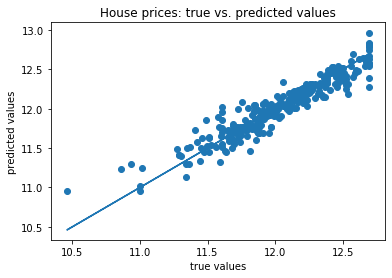

Mean absolute error of the prediction is: 0.09573110764646905
Mean squared error of the prediction is: 0.016827837852184804
Root mean squared error of the prediction is: 0.12972215636576814
Mean absolute percentage error of the prediction is: 0.8017149983459851


In [30]:
y_preds = results.predict(X_test)

# plot results against actual values
plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test)
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("House prices: true vs. predicted values")
plt.show()
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

Is the yearly morgage rate relevant to the house price? Let's add it to the model and test its significance. The source is [here](https://www.valuepenguin.com/mortgages/historical-mortgage-rates).

In [31]:
'This dataset contains house sales made between {} and {}.'.format(min(clean_house_prices['yrsold']),max(clean_house_prices['yrsold']))

'This dataset contains house sales made between 2006 and 2010.'

In [32]:
mor_rate = [6.41, 6.34, 6.03, 5.04, 4.69]
yrs = [i for i in range(2006,2011)]
Mortgage_Rate = {i:n for i in yrs for n in mor_rate}

clean_house_prices['Mortgage_Rate'] = [Mortgage_Rate[i] for i in clean_house_prices['yrsold']]

In [33]:
Y = np.log1p(clean_house_prices['saleprice_winsorized'])
X = clean_house_prices[['overallqual_winsorized','grlivarea_winsorized','overallcond_winsorized','yearbuilt','garagecars_winsorized','quality_per_sf','kitchenabvgr','Mortgage_Rate']+ dummy_column_names]
X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     saleprice_winsorized   R-squared:                       0.872
Model:                              OLS   Adj. R-squared:                  0.871
Method:                   Least Squares   F-statistic:                     718.3
Date:                  Mon, 13 Jan 2020   Prob (F-statistic):               0.00
Time:                          00:43:29   Log-Likelihood:                 694.84
No. Observations:                  1168   AIC:                            -1366.
Df Residuals:                      1156   BIC:                            -1305.
Df Model:                            11                                         
Covariance Type:              nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
overallqual_winsorized     0.1382      0.006     22.940      0.000       0.126       0.150
grlivarea_winsorized       0.0001   1.66e-05      8.577      0.000       0.000       0.000
overallcond_winsorized     0.0753      0.005     14.979      0.000       0.065       0.085
yearbuilt                  0.0026      0.000     12.543      0.000       0.002       0.003
garagecars_winsorized      0.0711      0.007      9.547      0.000       0.056       0.086
quality_per_sf          -169.3356     11.565    -14.642      0.000    -192.026    -146.645
kitchenabvgr              -0.0843      0.019     -4.428      0.000      -0.122      -0.047
Mortgage_Rate              1.1821      0.086     13.718      0.000       1.013       1.351
mszoning_FV                0.3766      0.053      7.089      0.000       0.272       0.481
mszoning_RH                0.2929      0.060      4.855      0.000       0.175       0.411
mszoning_RL                0.3302      0.049      6.749      0.000       0.234       0.426
mszoning_RM                0.2172      0.049      4.404      0.000       0.120       0.314
==============================================================================
Omnibus:                      351.850   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2340.019
Skew:                          -1.219   Prob(JB):                         0.00
Kurtosis:                       9.491   Cond. No.                     7.36e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.36e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The morgage rate variable did not affect the r-squared in the model.
Despite this, the t-score is extemely high, meaning that it probably is very related to salesprice.